In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install scikit-learn

In [ ]:
import pandas as pd
train=pd.read_csv('/content/drive/MyDrive/BBB dataset/bbb_cns_train.csv')
val=pd.read_csv('/content/drive/MyDrive/BBB dataset/bbb_cns_val.csv')
test=pd.read_csv('/content/drive/MyDrive/BBB dataset/bbb_cns_test.csv')
total=pd.read_csv('/content/drive/MyDrive/BBB dataset/total.csv')

In [ ]:
total

,smiles_standarized,label,group
0,O=NN(CCCl)C(=O)NC1CCC(=O)NC1=O,-2.8,training
1,CCCN(CCC)S(=O)(=O)c1ccc(C(=O)O)cc1,-3.9,training
2,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,-3.5,training
3,CN=C(NC#N)NCCSCc1[nH]cnc1C,-4.1,training
4,O=c1[nH]cnc2c1ncn2[C@H]1CC[C@@H](CO)O1,-4.5,training
...,...,...,...
148,Cn1c(=O)c2[nH]cnc2n(C)c1=O,-2.9,val
149,Cc1cc(=O)n(-c2ccccc2)n1C,-2.0,val
150,Cn1cc(O)nc1N,-4.6,val
151,O=c1[nH]c(=O)c2[nH]cnc2[nH]1,-3.8,val


In [ ]:
!pip install rdkit-pypi
!pip install pandas
!pip install Pillow
!pip install matplotlib
!pip install pydot
!sudo apt-get -qq install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 17.4 MB/s eta 0:00:00


In [ ]:
import os

# Temporary suppress tf logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage

# Temporary suppress warnings and RDKit logs
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output


class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def symbol(self, atom):
        return atom.GetSymbol()

    def n_valence(self, atom):
        return atom.GetTotalValence()

    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()

    def atomic_number(self,atom):
        return atom.GetAtomicNum()

    def formal_charge(self,atom):
        return atom.GetFormalCharge()

    def degree(self,atom):
        return atom.GetDegree()

    def implicit_valence(self,atom):
        return atom.GetImplicitValence()

    def is_aromatic(self,atom):
        return atom.GetIsAromatic()

    def atomic_mass(self,atom):
        return atom.GetMass()

    def vdw_radius(self,atom):
        vdw_radii={
            'H' : 1.20, 'C' : 1.70, 'N' : 1.55, 'O' : 1.52, 'F' : 1.47,
            'P' : 1.80, 'S' : 1.80, 'Cl' : 1.75, 'Br' : 1.85, 'I' : 1.98
        }
        return vdw_radii.get(atom.GetSymbol(), 0.0)

    def partial_charge(self,atom):
        return float(atom.GetProp("_GasteigerCharge")) if atom.HasProp("_GasteigerCharge") else 0.0

    def is_in_ring(self,atom):
        return atom.IsInRing()

    def chirality(self,atom):
        return atom.GetChiralTag().name.lower()


class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()


atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)


In [ ]:

def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule


def graph_from_molecule(molecule):
    # Initialize graph
    atom_features = []
    bond_features = []
    pair_indices = []

    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        # Add self-loops
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)


def graphs_from_smiles(smiles_list):
    # Initialize graphs
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    # Convert lists to ragged tensors for tf.data.Dataset later on
    return (
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),
    )


# Shuffle array of indices ranging from 0 to 2049
permuted_indices = np.random.permutation(np.arange(total.shape[0]))

# Train set: 80 % of data
train_index = permuted_indices[: int(total.shape[0] * 0.8)]
x_train = graphs_from_smiles(total.iloc[train_index].smiles_standarized)
y_train = total.iloc[train_index].label

# Valid set: 19 % of data
valid_index = permuted_indices[int(total.shape[0] * 0.8) : int(total.shape[0] * 0.99)]
x_valid = graphs_from_smiles(total.iloc[valid_index].smiles_standarized)
y_valid = total.iloc[valid_index].label

# Test set: 1 % of data
test_index = permuted_indices[int(total.shape[0] * 0.99) :]
x_test = graphs_from_smiles(total.iloc[test_index].smiles_standarized)
y_test = total.iloc[test_index].label


SMILES:	Clc1ccc2c(c1)C(N1CCNCC1)=Nc1ccccc1O2
Label:	-1.2
Molecule:


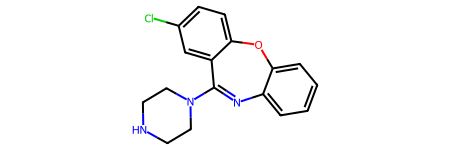

In [ ]:
print(f"SMILES:\t{train.smiles_standarized[100]}\nLabel:\t{train.label[100]}")
molecule = molecule_from_smiles(train.iloc[100].smiles_standarized)
print("Molecule:")
molecule

In [ ]:
graph = graph_from_molecule(molecule)
print("Graph (including self-loops):")
print("\tatom features\t", graph[0].shape)
print("\tbond features\t", graph[1].shape)
print("\tpair indices\t", graph[2].shape)

Graph (including self-loops):
	atom features	 (22, 29)
	bond features	 (72, 7)
	pair indices	 (72, 2)


In [ ]:
def prepare_batch(x_batch, y_batch):
    """Merges (sub)graphs of batch into a single global (disconnected) graph
    """

    atom_features, bond_features, pair_indices = x_batch

    # Obtain number of atoms and bonds for each graph (molecule)
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    # Obtain partition indices (molecule_indicator), which will be used to
    # gather (sub)graphs from global graph in model later on
    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)

    # Merge (sub)graphs into a global (disconnected) graph. Adding 'increment' to
    # 'pair_indices' (and merging ragged tensors) actualizes the global graph
    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch


def MPNNDataset(X, y, batch_size=32, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)

In [ ]:
class EdgeNetwork(layers.Layer):
    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            initializer="glorot_uniform",
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim), initializer="zeros", name="bias",
        )
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Apply linear transformation to bond features
        bond_features = tf.matmul(bond_features, self.kernel) + self.bias

        # Reshape for neighborhood aggregation later
        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))

        # Obtain atom features of neighbors
        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis=-1)

        # Apply neighborhood aggregation
        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis=-1)
        aggregated_features = tf.math.unsorted_segment_sum(
            transformed_features,
            pair_indices[:, 0],
            num_segments=tf.shape(atom_features)[0],
        )
        return aggregated_features


class MessagePassing(layers.Layer):
    def __init__(self, units, steps=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Pad atom features if number of desired units exceeds atom_features dim.
        # Alternatively, a dense layer could be used here.
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])

        # Perform a number of steps of message passing
        for i in range(self.steps):
            # Aggregate information from neighbors
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )

            # Update node state via a step of GRU
            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated


In [ ]:
class PartitionPadding(layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):

        atom_features, molecule_indicator = inputs

        # Obtain subgraphs
        atom_features_partitioned = tf.dynamic_partition(
            atom_features, molecule_indicator, self.batch_size
        )

        # Pad and stack subgraphs
        num_atoms = [tf.shape(f)[0] for f in atom_features_partitioned]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_stacked = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features_partitioned, num_atoms)
            ],
            axis=0,
        )

        # Remove empty subgraphs (usually for last batch in dataset)
        gather_indices = tf.where(tf.reduce_sum(atom_features_stacked, (1, 2)) != 0)
        gather_indices = tf.squeeze(gather_indices, axis=-1)
        return tf.gather(atom_features_stacked, gather_indices, axis=0)


class TransformerEncoderReadout(layers.Layer):
    def __init__(
        self, num_heads=8, embed_dim=64, dense_dim=512, batch_size=32, **kwargs
    ):
        super().__init__(**kwargs)

        self.partition_padding = PartitionPadding(batch_size)
        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.average_pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs):
        x = self.partition_padding(inputs)
        padding_mask = tf.reduce_any(tf.not_equal(x, 0.0), axis=-1)
        padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]
        attention_output = self.attention(x, x, attention_mask=padding_mask)
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))
        return self.average_pooling(proj_output)

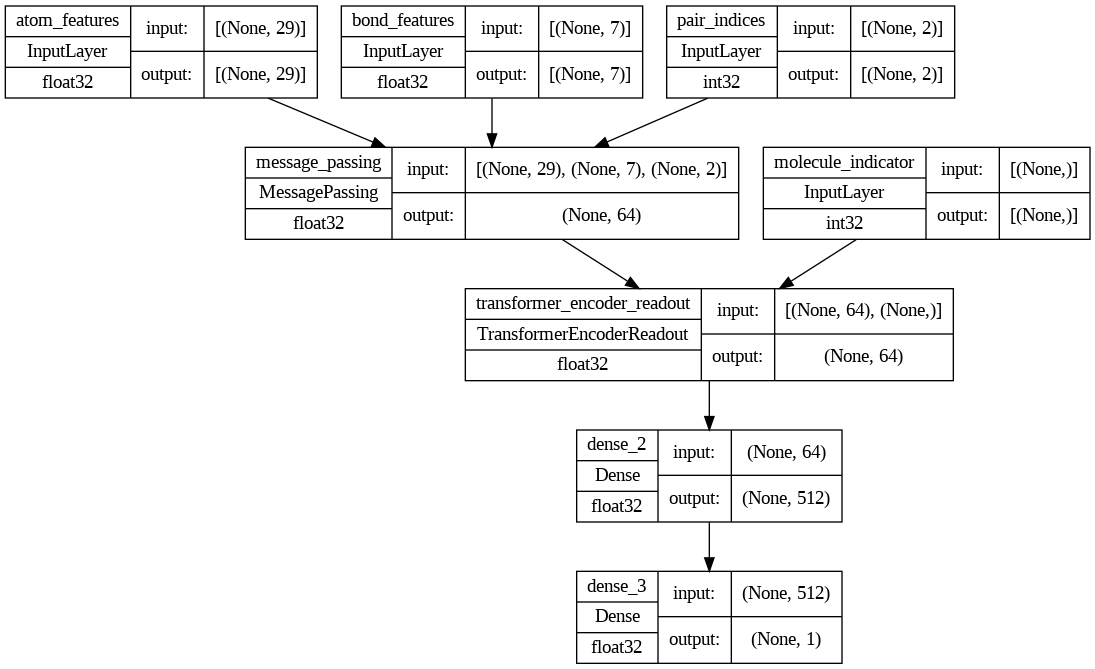

In [ ]:
def MPNNModel(
    atom_dim,
    bond_dim,
    batch_size=32,
    message_units=64,
    message_steps=4,
    num_attention_heads=8,
    dense_units=512,
):

    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    )

    x = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size
    )([x, molecule_indicator])

    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dense(1, activation=None)(x)

    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x],
    )
    return model


mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)

mpnn.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[keras.metrics.MeanAbsoluteError(name="MAE")],
)

keras.utils.plot_model(mpnn, show_dtype=True, show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# TEST 1:

In [ ]:
# Shuffle array of indices ranging from 0 to 2049
permuted_indices = np.random.permutation(np.arange(total.shape[0]))

# Train set: 80 % of data
train_index = permuted_indices[: int(total.shape[0] * 0.8)]
x_train = graphs_from_smiles(total.iloc[train_index].smiles_standarized)
y_train = total.iloc[train_index].label

# Valid set: 20 % of data
valid_index = permuted_indices[int(total.shape[0] * 0.8) : ]
x_valid = graphs_from_smiles(total.iloc[valid_index].smiles_standarized)
y_valid = total.iloc[valid_index].label


In [ ]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=40,
    verbose=2,
    callbacks=[early_stopping]
)


Epoch 1/40
4/4 - 15s - loss: 3.5557 - MAE: 1.4482 - val_loss: 1.3308 - val_MAE: 1.0156 - 15s/epoch - 4s/step
Epoch 2/40
4/4 - 2s - loss: 1.3053 - MAE: 0.9596 - val_loss: 0.8856 - val_MAE: 0.7348 - 2s/epoch - 442ms/step
Epoch 3/40
4/4 - 1s - loss: 1.2365 - MAE: 0.9288 - val_loss: 1.0787 - val_MAE: 0.8986 - 1s/epoch - 354ms/step
Epoch 4/40
4/4 - 1s - loss: 1.1151 - MAE: 0.8852 - val_loss: 0.8246 - val_MAE: 0.7004 - 1s/epoch - 375ms/step
Epoch 5/40
4/4 - 2s - loss: 1.0521 - MAE: 0.8486 - val_loss: 0.9033 - val_MAE: 0.7829 - 2s/epoch - 575ms/step
Epoch 6/40
4/4 - 2s - loss: 0.9432 - MAE: 0.7808 - val_loss: 0.6241 - val_MAE: 0.6057 - 2s/epoch - 437ms/step
Epoch 7/40
4/4 - 2s - loss: 0.9007 - MAE: 0.7800 - val_loss: 0.6046 - val_MAE: 0.5993 - 2s/epoch - 437ms/step
Epoch 8/40
4/4 - 2s - loss: 0.8193 - MAE: 0.7222 - val_loss: 0.7209 - val_MAE: 0.6594 - 2s/epoch - 386ms/step
Epoch 9/40
4/4 - 3s - loss: 0.7877 - MAE: 0.6967 - val_loss: 0.6664 - val_MAE: 0.6541 - 3s/epoch - 715ms/step
Epoch 10/40

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

train_predictions = mpnn.predict(train_dataset)
train_loss, train_mae = mpnn.evaluate(train_dataset)
print(f"Train MAE: {train_mae}")

r2_train = r2_score(y_train, train_predictions)
print(f"Training R-squared: {r2_train}")



4/4 [==============================] - 1s 126ms/step - loss: 0.8222 - MAE: 0.7187
Train MAE: 0.7186810374259949
Training R-squared: 0.38282373395650904


1/1 [==============================] - 0s 227ms/step


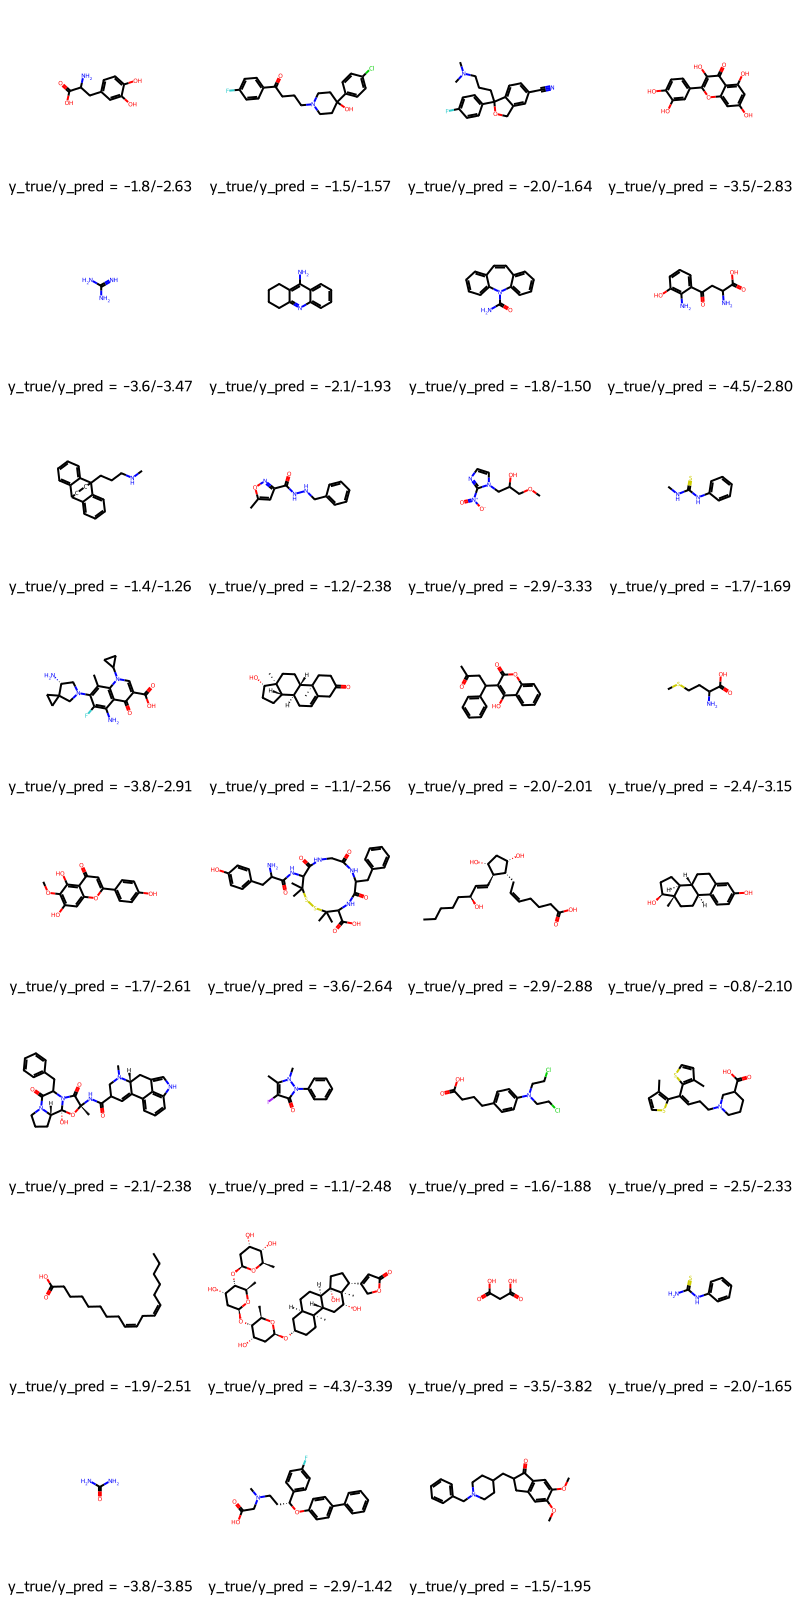

In [ ]:
molecules = [molecule_from_smiles(total.smiles_standarized.values[index]) for index in valid_index]
y_true = [total.label.values[index] for index in valid_index]
y_pred = tf.squeeze(mpnn.predict(valid_dataset), axis=1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
valid_dataset = MPNNDataset(x_valid, y_valid)
test_loss, test_mae = mpnn.evaluate(valid_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

predictions = mpnn.predict(valid_dataset)
r2 = r2_score(y_valid, predictions)
print(f"R^2 Score: {r2}")

1/1 [==============================] - 0s 416ms/step - loss: 0.6046 - MAE: 0.5993
Test Loss: 0.6046046614646912
Test MAE: 0.5992833971977234
1/1 [==============================] - 0s 364ms/step
R^2 Score: 0.39973028704701086


1/1 [==============================] - 0s 289ms/step
Shape of y_test: (31,)
Shape of y_pred: (31,)
Mean Absolute Error (MAE): 0.5992833860458865
Mean Squared Error (MSE): 0.6046046471963749


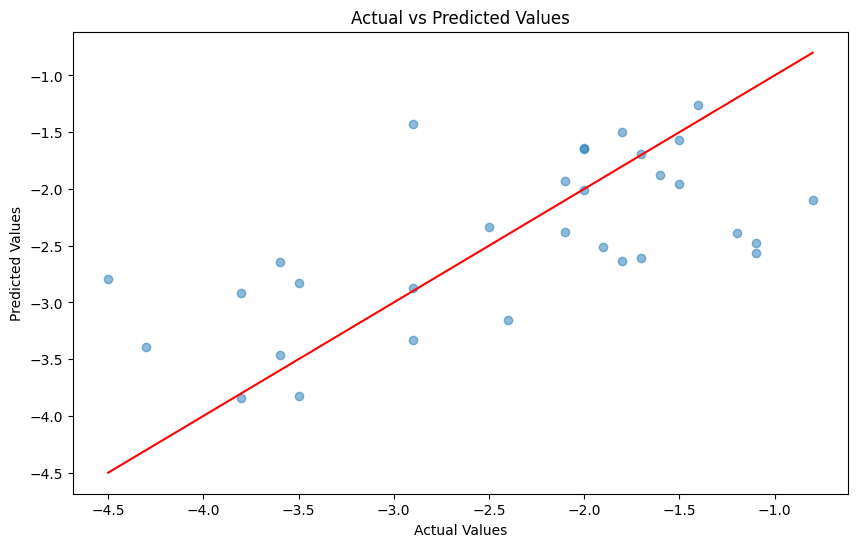

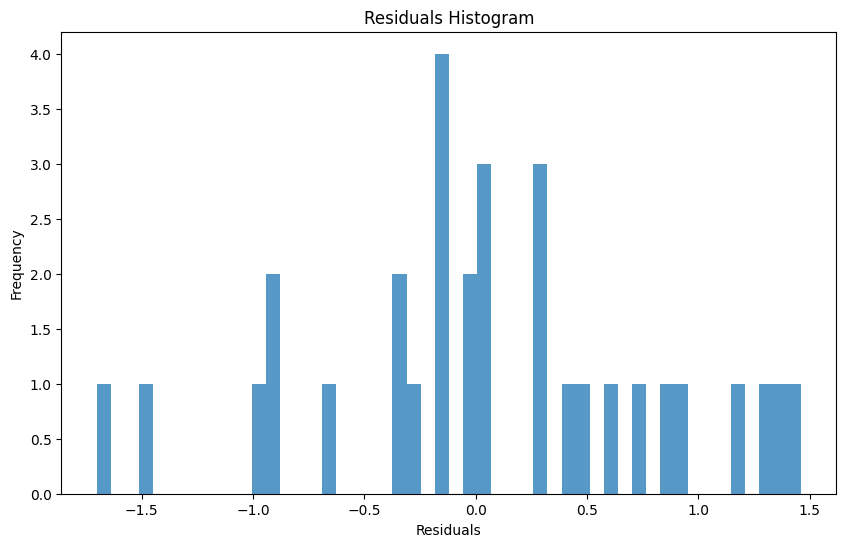

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Load the test dataset and make predictions
test_dataset = MPNNDataset(x_valid, y_valid)
y_pred = mpnn.predict(valid_dataset)

# Ensure y_test and y_pred are numpy arrays
y_test = np.array(y_valid)
y_pred = np.array(y_pred).squeeze()  # Remove the extra dimension if it exists

# Check the shape of y_test and y_pred
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line of perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

# Plot residuals (errors)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.75)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()


In [ ]:
# TEST 2:

In [ ]:
# Shuffle array of indices ranging from 0 to 2049
permuted_indices = np.random.permutation(np.arange(total.shape[0]))

# Train set: 80 % of data
train_index = permuted_indices[: int(total.shape[0] * 0.8)]
x_train = graphs_from_smiles(total.iloc[train_index].smiles_standarized)
y_train = total.iloc[train_index].label

# Valid set: 20 % of data
valid_index = permuted_indices[int(total.shape[0] * 0.8) : ]
x_valid = graphs_from_smiles(total.iloc[valid_index].smiles_standarized)
y_valid = total.iloc[valid_index].label


In [ ]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=40,
    verbose=2,
    callbacks=[early_stopping]
)


Epoch 1/40
4/4 - 2s - loss: 0.7961 - MAE: 0.7223 - val_loss: 0.8704 - val_MAE: 0.7527 - 2s/epoch - 376ms/step
Epoch 2/40
4/4 - 1s - loss: 0.8278 - MAE: 0.7133 - val_loss: 0.9316 - val_MAE: 0.8198 - 1s/epoch - 357ms/step
Epoch 3/40
4/4 - 1s - loss: 0.7275 - MAE: 0.6949 - val_loss: 0.8725 - val_MAE: 0.7364 - 1s/epoch - 367ms/step
Epoch 4/40
4/4 - 2s - loss: 0.7326 - MAE: 0.6678 - val_loss: 0.8031 - val_MAE: 0.7501 - 2s/epoch - 571ms/step
Epoch 5/40
4/4 - 2s - loss: 0.6721 - MAE: 0.6455 - val_loss: 0.7648 - val_MAE: 0.7097 - 2s/epoch - 532ms/step
Epoch 6/40
4/4 - 1s - loss: 0.6244 - MAE: 0.6167 - val_loss: 0.7961 - val_MAE: 0.6916 - 1s/epoch - 353ms/step
Epoch 7/40
4/4 - 1s - loss: 0.6368 - MAE: 0.6141 - val_loss: 0.7330 - val_MAE: 0.7025 - 1s/epoch - 358ms/step
Epoch 8/40
4/4 - 2s - loss: 0.5937 - MAE: 0.6151 - val_loss: 0.7122 - val_MAE: 0.6735 - 2s/epoch - 398ms/step
Epoch 9/40
4/4 - 1s - loss: 0.5481 - MAE: 0.5798 - val_loss: 0.7105 - val_MAE: 0.6605 - 1s/epoch - 359ms/step
Epoch 10/4

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

train_predictions = mpnn.predict(train_dataset)
train_loss, train_mae = mpnn.evaluate(train_dataset)
print(f"Train MAE: {train_mae}")

r2_train = r2_score(y_train, train_predictions)
print(f"Training R-squared: {r2_train}")



4/4 [==============================] - 1s 115ms/step - loss: 0.4910 - MAE: 0.5476
Train MAE: 0.5475955605506897
Training R-squared: 0.6228270751969072


1/1 [==============================] - 0s 296ms/step


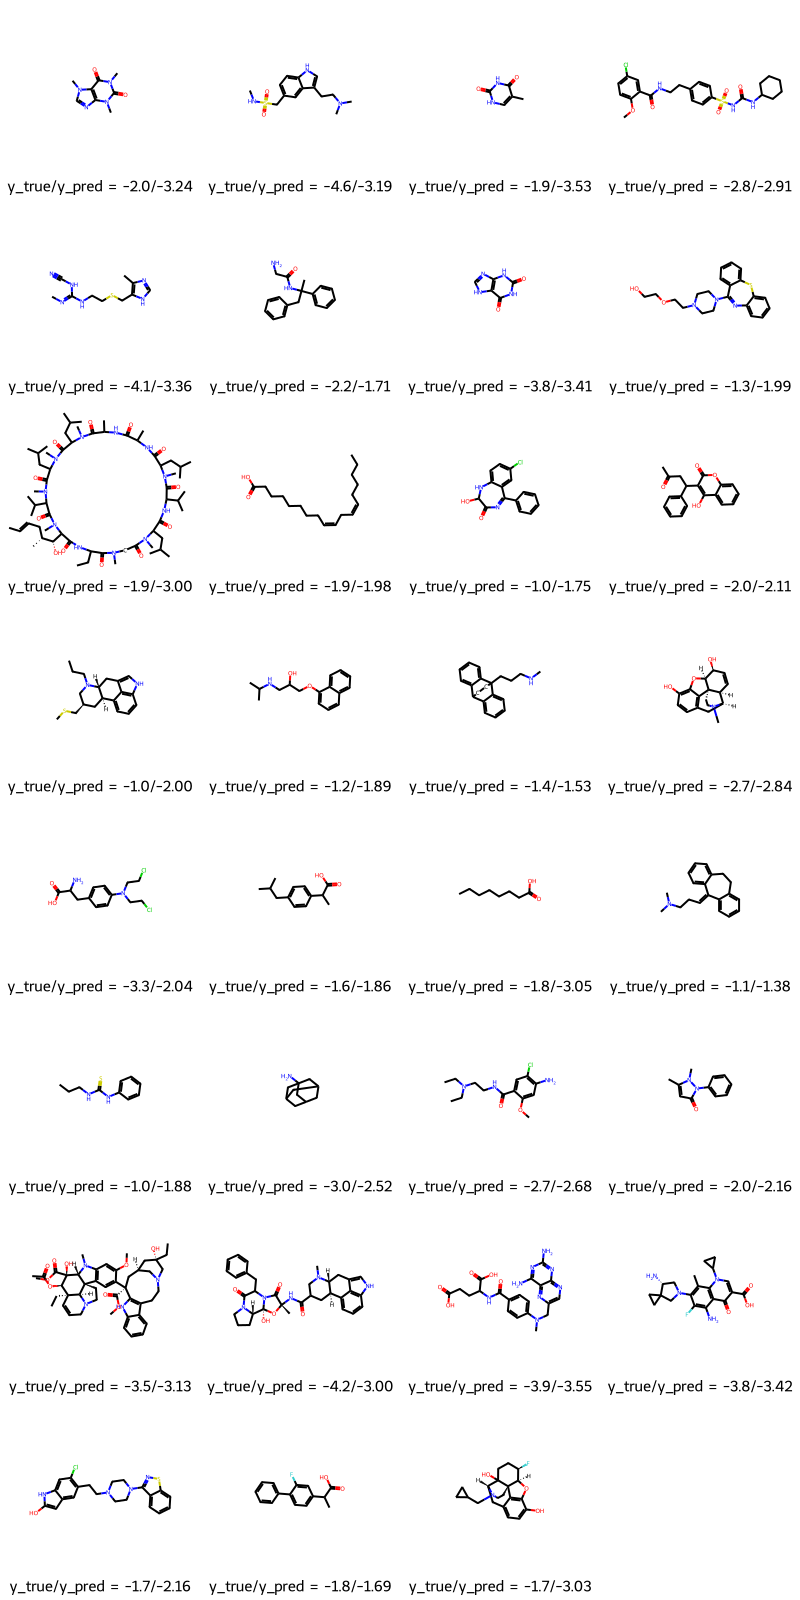

In [ ]:
molecules = [molecule_from_smiles(total.smiles_standarized.values[index]) for index in valid_index]
y_true = [total.label.values[index] for index in valid_index]
y_pred = tf.squeeze(mpnn.predict(valid_dataset), axis=1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)

In [ ]:
valid_dataset = MPNNDataset(x_valid, y_valid)
test_loss, test_mae = mpnn.evaluate(valid_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")



1/1 [==============================] - 0s 326ms/step - loss: 0.6133 - MAE: 0.6276
Test Loss: 0.613344132900238
Test MAE: 0.6275594234466553


In [ ]:
predictions = mpnn.predict(valid_dataset)


1/1 [==============================] - 0s 375ms/step


In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(y_valid, predictions)
print(f"R^2 Score: {r2}")

R^2 Score: 0.45074850406599065


1/1 [==============================] - 0s 286ms/step
Shape of y_test: (31,)
Shape of y_pred: (31,)
Mean Absolute Error (MAE): 0.6275594280612085
Mean Squared Error (MSE): 0.6133441730974222


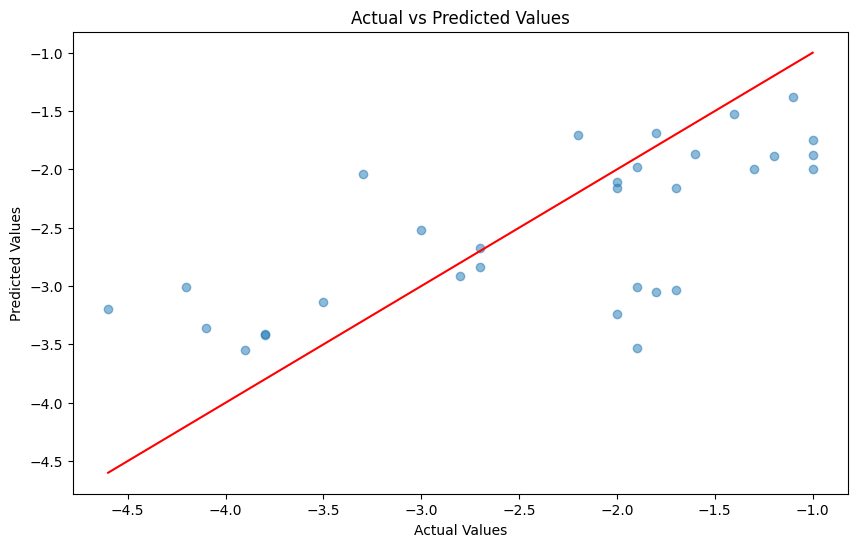

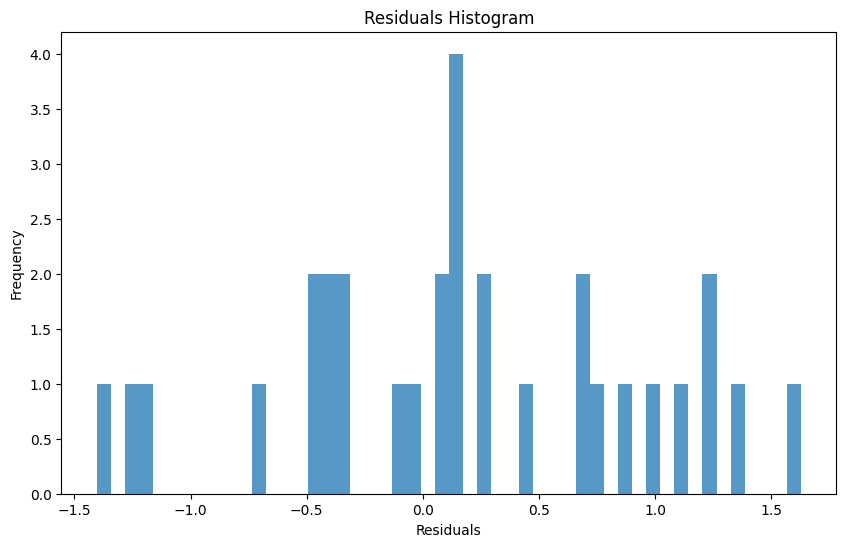

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Load the test dataset and make predictions
test_dataset = MPNNDataset(x_valid, y_valid)
y_pred = mpnn.predict(valid_dataset)

# Ensure y_test and y_pred are numpy arrays
y_test = np.array(y_valid)
y_pred = np.array(y_pred).squeeze()  # Remove the extra dimension if it exists

# Check the shape of y_test and y_pred
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line of perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

# Plot residuals (errors)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.75)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()


In [ ]:
# TEST 3:

In [ ]:
# Shuffle array of indices ranging from 0 to 2049
permuted_indices = np.random.permutation(np.arange(total.shape[0]))

# Train set: 80 % of data
train_index = permuted_indices[: int(total.shape[0] * 0.8)]
x_train = graphs_from_smiles(total.iloc[train_index].smiles_standarized)
y_train = total.iloc[train_index].label

# Valid set: 20 % of data
valid_index = permuted_indices[int(total.shape[0] * 0.8) : ]
x_valid = graphs_from_smiles(total.iloc[valid_index].smiles_standarized)
y_valid = total.iloc[valid_index].label


In [ ]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=40,
    verbose=2,
    callbacks=[early_stopping]
)


Epoch 1/40
4/4 - 2s - loss: 0.7478 - MAE: 0.6504 - val_loss: 0.9390 - val_MAE: 0.8533 - 2s/epoch - 611ms/step
Epoch 2/40
4/4 - 2s - loss: 0.7519 - MAE: 0.7280 - val_loss: 0.9539 - val_MAE: 0.8640 - 2s/epoch - 589ms/step
Epoch 3/40
4/4 - 3s - loss: 0.6967 - MAE: 0.6530 - val_loss: 0.8249 - val_MAE: 0.7373 - 3s/epoch - 722ms/step
Epoch 4/40
4/4 - 4s - loss: 0.6158 - MAE: 0.6146 - val_loss: 0.7982 - val_MAE: 0.7765 - 4s/epoch - 1s/step
Epoch 5/40
4/4 - 4s - loss: 0.6546 - MAE: 0.6296 - val_loss: 0.7906 - val_MAE: 0.7178 - 4s/epoch - 1s/step
Epoch 6/40
4/4 - 3s - loss: 0.5453 - MAE: 0.5801 - val_loss: 0.8091 - val_MAE: 0.7611 - 3s/epoch - 639ms/step
Epoch 7/40
4/4 - 4s - loss: 0.5726 - MAE: 0.5999 - val_loss: 0.8629 - val_MAE: 0.7475 - 4s/epoch - 1s/step
Epoch 8/40
4/4 - 2s - loss: 0.4975 - MAE: 0.5518 - val_loss: 0.9031 - val_MAE: 0.7714 - 2s/epoch - 565ms/step
Epoch 9/40
4/4 - 2s - loss: 0.5133 - MAE: 0.5646 - val_loss: 0.7696 - val_MAE: 0.7084 - 2s/epoch - 415ms/step
Epoch 10/40
4/4 - 2

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

train_predictions = mpnn.predict(train_dataset)
train_loss, train_mae = mpnn.evaluate(train_dataset)
print(f"Train MAE: {train_mae}")

r2_train = r2_score(y_train, train_predictions)
print(f"Training R-squared: {r2_train}")



4/4 [==============================] - 1s 110ms/step - loss: 0.4597 - MAE: 0.5239
Train MAE: 0.5239328742027283
Training R-squared: 0.5888917195140355


1/1 [==============================] - 0s 234ms/step


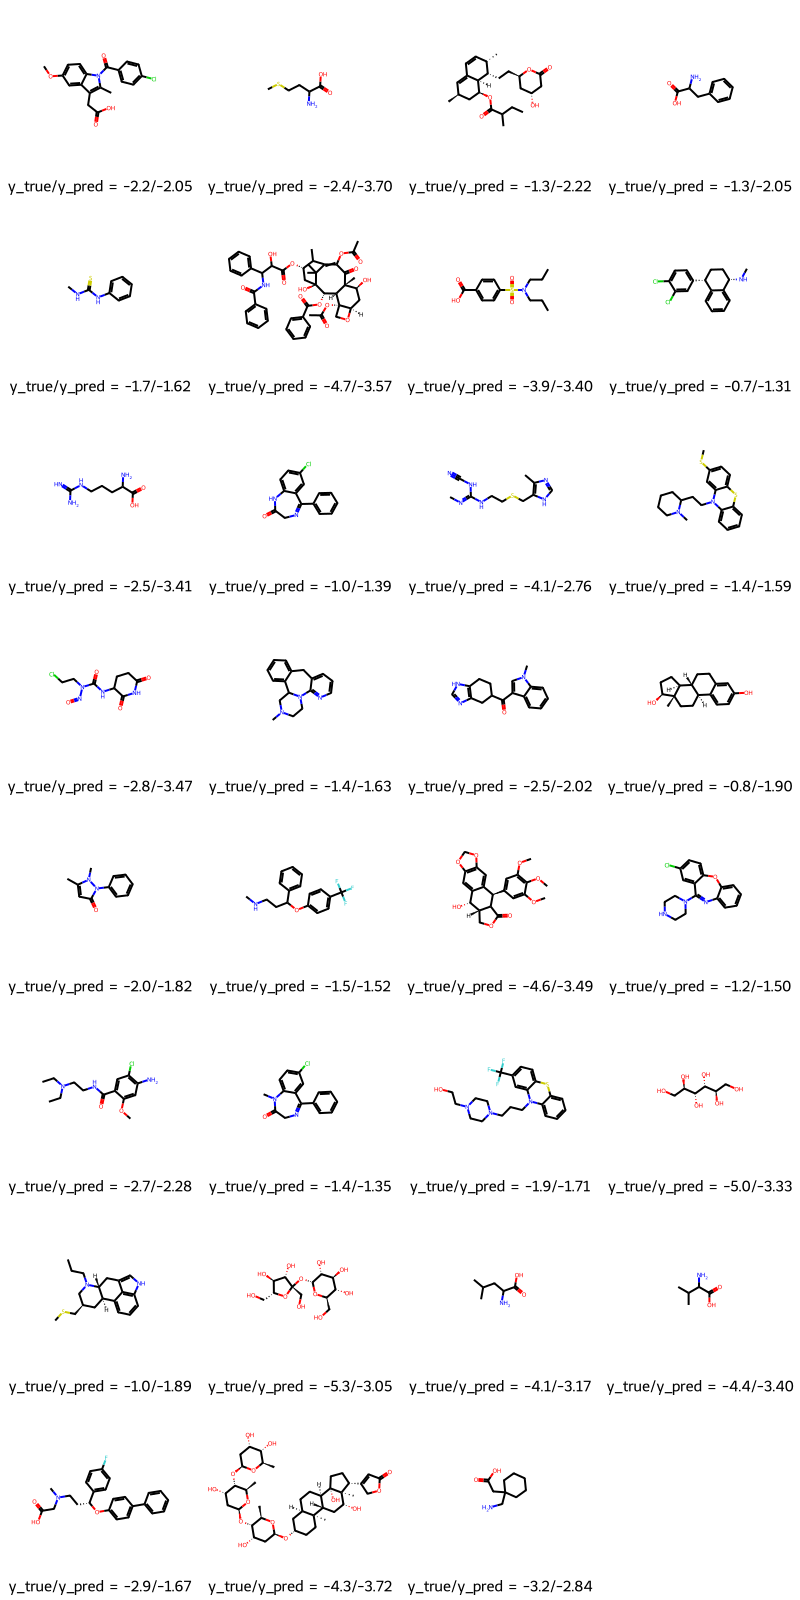

In [ ]:
molecules = [molecule_from_smiles(total.smiles_standarized.values[index]) for index in valid_index]
y_true = [total.label.values[index] for index in valid_index]
y_pred = tf.squeeze(mpnn.predict(valid_dataset), axis=1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)

In [ ]:
valid_dataset = MPNNDataset(x_valid, y_valid)
test_loss, test_mae = mpnn.evaluate(valid_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

predictions = mpnn.predict(valid_dataset)
r2 = r2_score(y_valid, predictions)
print(f"R^2 Score: {r2}")

1/1 [==============================] - 0s 439ms/step - loss: 0.7696 - MAE: 0.7084
Test Loss: 0.7696214318275452
Test MAE: 0.7083663940429688
1/1 [==============================] - 0s 343ms/step
R^2 Score: 0.5955871935515469


1/1 [==============================] - 0s 216ms/step
Shape of y_test: (31,)
Shape of y_pred: (31,)
Mean Absolute Error (MAE): 0.7083664086557204
Mean Squared Error (MSE): 0.7696215576953057


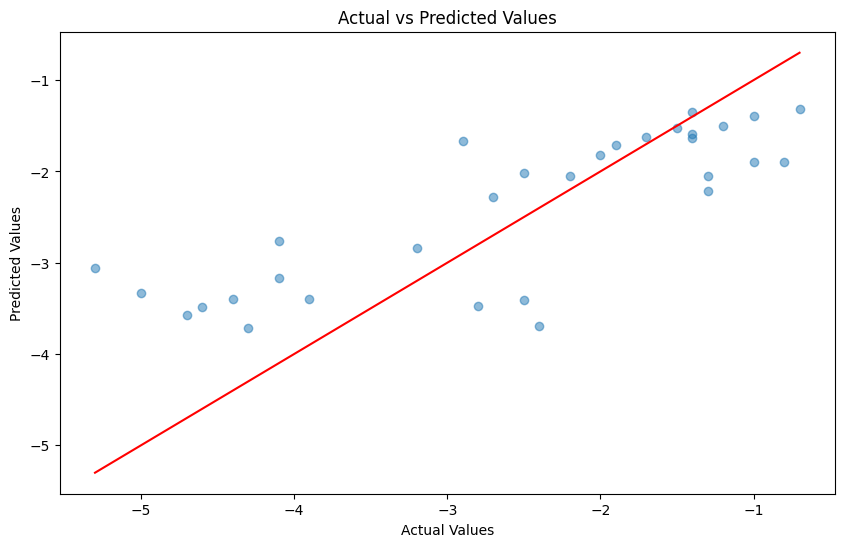

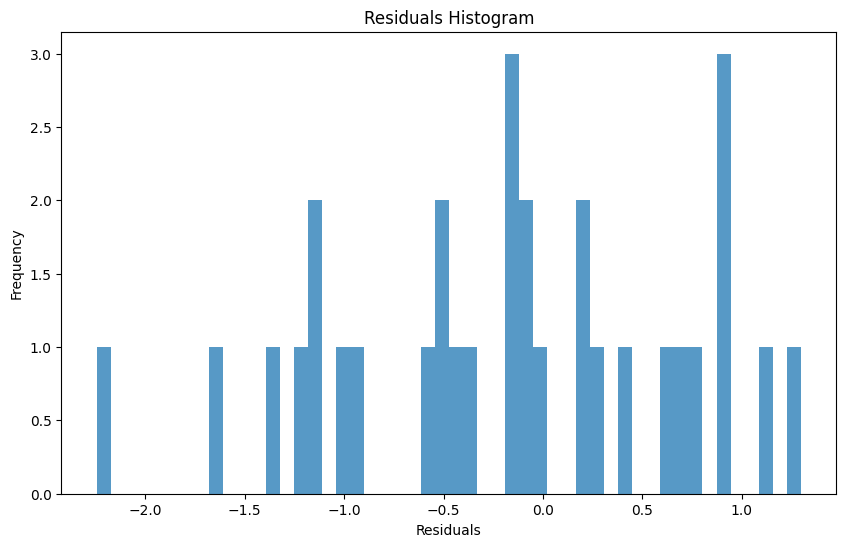

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Load the test dataset and make predictions
test_dataset = MPNNDataset(x_valid, y_valid)
y_pred = mpnn.predict(valid_dataset)

# Ensure y_test and y_pred are numpy arrays
y_test = np.array(y_valid)
y_pred = np.array(y_pred).squeeze()  # Remove the extra dimension if it exists

# Check the shape of y_test and y_pred
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line of perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

# Plot residuals (errors)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.75)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()


In [ ]:
#TEST 4:

In [ ]:
# Shuffle array of indices ranging from 0 to 2049
permuted_indices = np.random.permutation(np.arange(total.shape[0]))

# Train set: 80 % of data
train_index = permuted_indices[: int(total.shape[0] * 0.8)]
x_train = graphs_from_smiles(total.iloc[train_index].smiles_standarized)
y_train = total.iloc[train_index].label

# Valid set: 20 % of data
valid_index = permuted_indices[int(total.shape[0] * 0.8) : ]
x_valid = graphs_from_smiles(total.iloc[valid_index].smiles_standarized)
y_valid = total.iloc[valid_index].label


In [ ]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=40,
    verbose=2,
    callbacks=[early_stopping]
)


Epoch 1/40
4/4 - 2s - loss: 0.5880 - MAE: 0.6070 - val_loss: 0.4012 - val_MAE: 0.4913 - 2s/epoch - 511ms/step
Epoch 2/40
4/4 - 2s - loss: 0.4900 - MAE: 0.5429 - val_loss: 0.3780 - val_MAE: 0.4960 - 2s/epoch - 620ms/step
Epoch 3/40
4/4 - 1s - loss: 0.5252 - MAE: 0.5745 - val_loss: 0.4455 - val_MAE: 0.5363 - 1s/epoch - 372ms/step
Epoch 4/40
4/4 - 2s - loss: 0.4689 - MAE: 0.5339 - val_loss: 0.4593 - val_MAE: 0.5122 - 2s/epoch - 419ms/step
Epoch 5/40
4/4 - 2s - loss: 0.4214 - MAE: 0.5002 - val_loss: 0.4275 - val_MAE: 0.5238 - 2s/epoch - 408ms/step
Epoch 6/40
4/4 - 2s - loss: 0.4360 - MAE: 0.5167 - val_loss: 0.4540 - val_MAE: 0.5348 - 2s/epoch - 391ms/step
Epoch 7/40
4/4 - 3s - loss: 0.4139 - MAE: 0.4951 - val_loss: 0.4623 - val_MAE: 0.5168 - 3s/epoch - 626ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

train_predictions = mpnn.predict(train_dataset)
train_loss, train_mae = mpnn.evaluate(train_dataset)
print(f"Train MAE: {train_mae}")

r2_train = r2_score(y_train, train_predictions)
print(f"Training R-squared: {r2_train}")



4/4 [==============================] - 1s 107ms/step - loss: 0.4904 - MAE: 0.5468
Train MAE: 0.5467827320098877
Training R-squared: 0.620849016841249


1/1 [==============================] - 0s 346ms/step


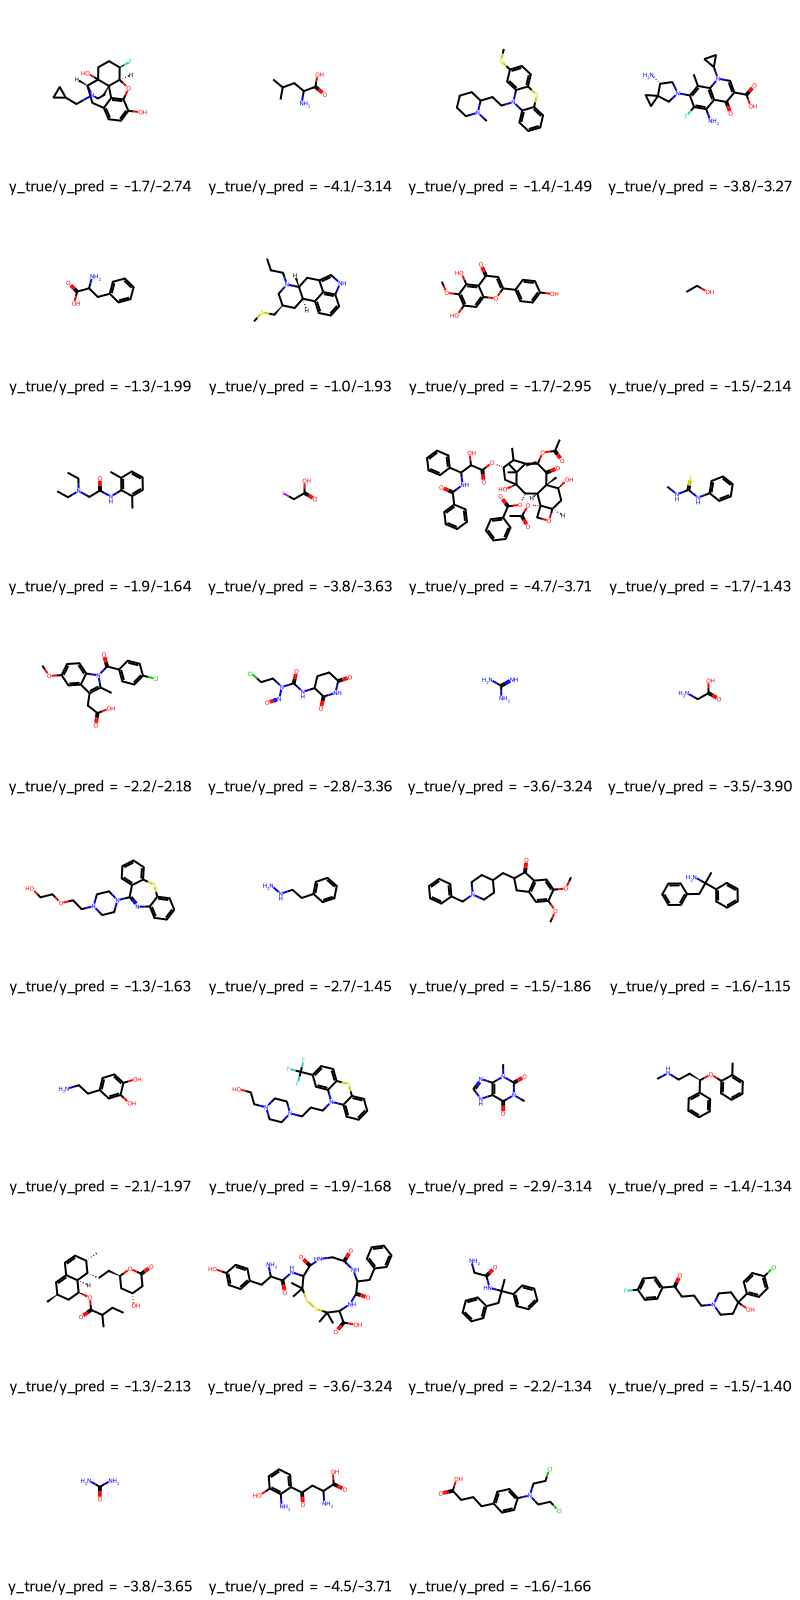

In [ ]:
molecules = [molecule_from_smiles(total.smiles_standarized.values[index]) for index in valid_index]
y_true = [total.label.values[index] for index in valid_index]
y_pred = tf.squeeze(mpnn.predict(valid_dataset), axis=1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)

In [ ]:
valid_dataset = MPNNDataset(x_valid, y_valid)
test_loss, test_mae = mpnn.evaluate(valid_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

predictions = mpnn.predict(valid_dataset)
r2 = r2_score(y_valid, predictions)
print(f"R^2 Score: {r2}")

1/1 [==============================] - 0s 280ms/step - loss: 0.3612 - MAE: 0.4605
Test Loss: 0.3612247705459595
Test MAE: 0.46053415536880493
1/1 [==============================] - 0s 230ms/step
R^2 Score: 0.693195470433716


1/1 [==============================] - 0s 190ms/step
Shape of y_test: (31,)
Shape of y_pred: (31,)
Mean Absolute Error (MAE): 0.49600231186036153
Mean Squared Error (MSE): 0.3779841516806386


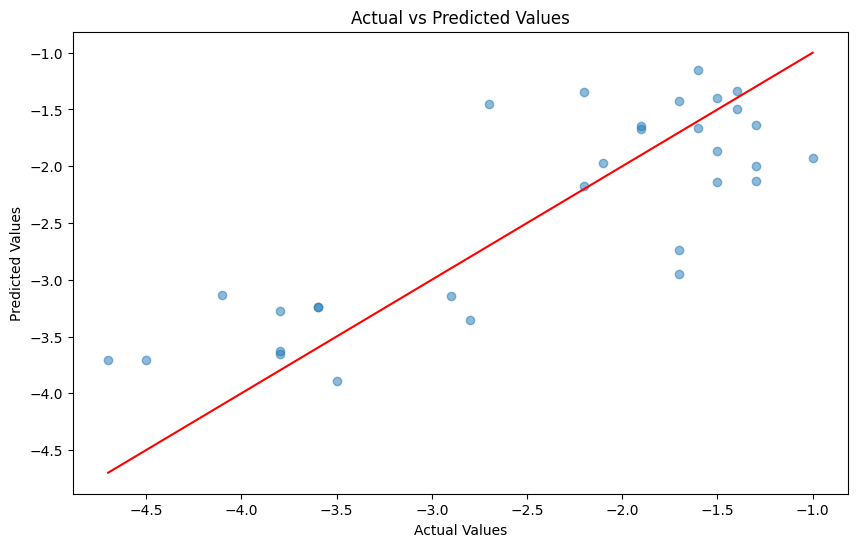

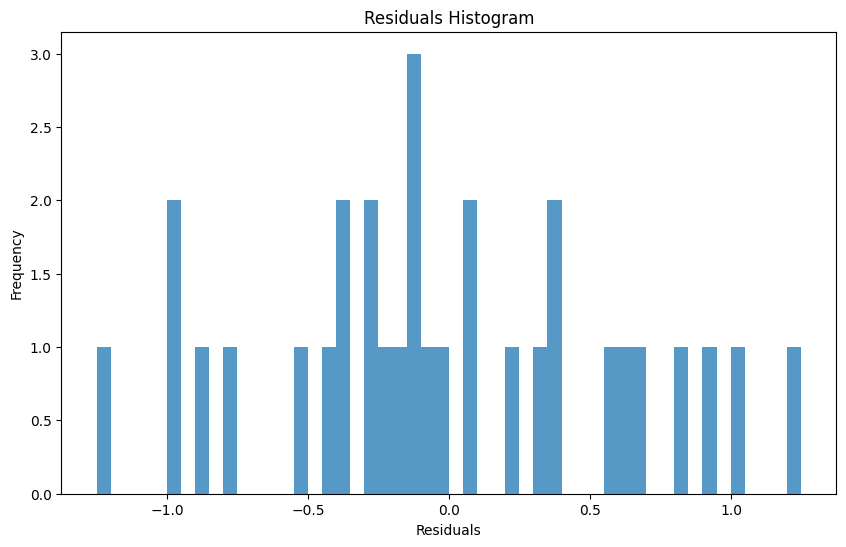

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Load the test dataset and make predictions
test_dataset = MPNNDataset(x_valid, y_valid)
y_pred = mpnn.predict(valid_dataset)

# Ensure y_test and y_pred are numpy arrays
y_test = np.array(y_valid)
y_pred = np.array(y_pred).squeeze()  # Remove the extra dimension if it exists

# Check the shape of y_test and y_pred
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line of perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

# Plot residuals (errors)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.75)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()


In [ ]:
#TEST 5:

In [ ]:
# Shuffle array of indices ranging from 0 to 2049
permuted_indices = np.random.permutation(np.arange(total.shape[0]))

# Train set: 80 % of data
train_index = permuted_indices[: int(total.shape[0] * 0.8)]
x_train = graphs_from_smiles(total.iloc[train_index].smiles_standarized)
y_train = total.iloc[train_index].label

# Valid set: 20 % of data
valid_index = permuted_indices[int(total.shape[0] * 0.8) : ]
x_valid = graphs_from_smiles(total.iloc[valid_index].smiles_standarized)
y_valid = total.iloc[valid_index].label


In [ ]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=40,
    verbose=2,
    callbacks=[early_stopping]
)


Epoch 1/40
4/4 - 2s - loss: 0.5094 - MAE: 0.5551 - val_loss: 0.5240 - val_MAE: 0.6036 - 2s/epoch - 381ms/step
Epoch 2/40
4/4 - 1s - loss: 0.5173 - MAE: 0.5381 - val_loss: 0.6312 - val_MAE: 0.6394 - 1s/epoch - 350ms/step
Epoch 3/40
4/4 - 1s - loss: 0.4496 - MAE: 0.5156 - val_loss: 0.5548 - val_MAE: 0.6204 - 1s/epoch - 360ms/step
Epoch 4/40
4/4 - 1s - loss: 0.4512 - MAE: 0.5137 - val_loss: 0.6217 - val_MAE: 0.6746 - 1s/epoch - 370ms/step
Epoch 5/40
4/4 - 2s - loss: 0.3994 - MAE: 0.4865 - val_loss: 0.5260 - val_MAE: 0.6046 - 2s/epoch - 594ms/step
Epoch 6/40
4/4 - 2s - loss: 0.3763 - MAE: 0.4617 - val_loss: 0.6403 - val_MAE: 0.6622 - 2s/epoch - 608ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

train_predictions = mpnn.predict(train_dataset)
train_loss, train_mae = mpnn.evaluate(train_dataset)
print(f"Train MAE: {train_mae}")

r2_train = r2_score(y_train, train_predictions)
print(f"Training R-squared: {r2_train}")



4/4 [==============================] - 1s 147ms/step - loss: 0.5016 - MAE: 0.5489
Train MAE: 0.5488945245742798
Training R-squared: 0.6143636687108813


1/1 [==============================] - 0s 207ms/step


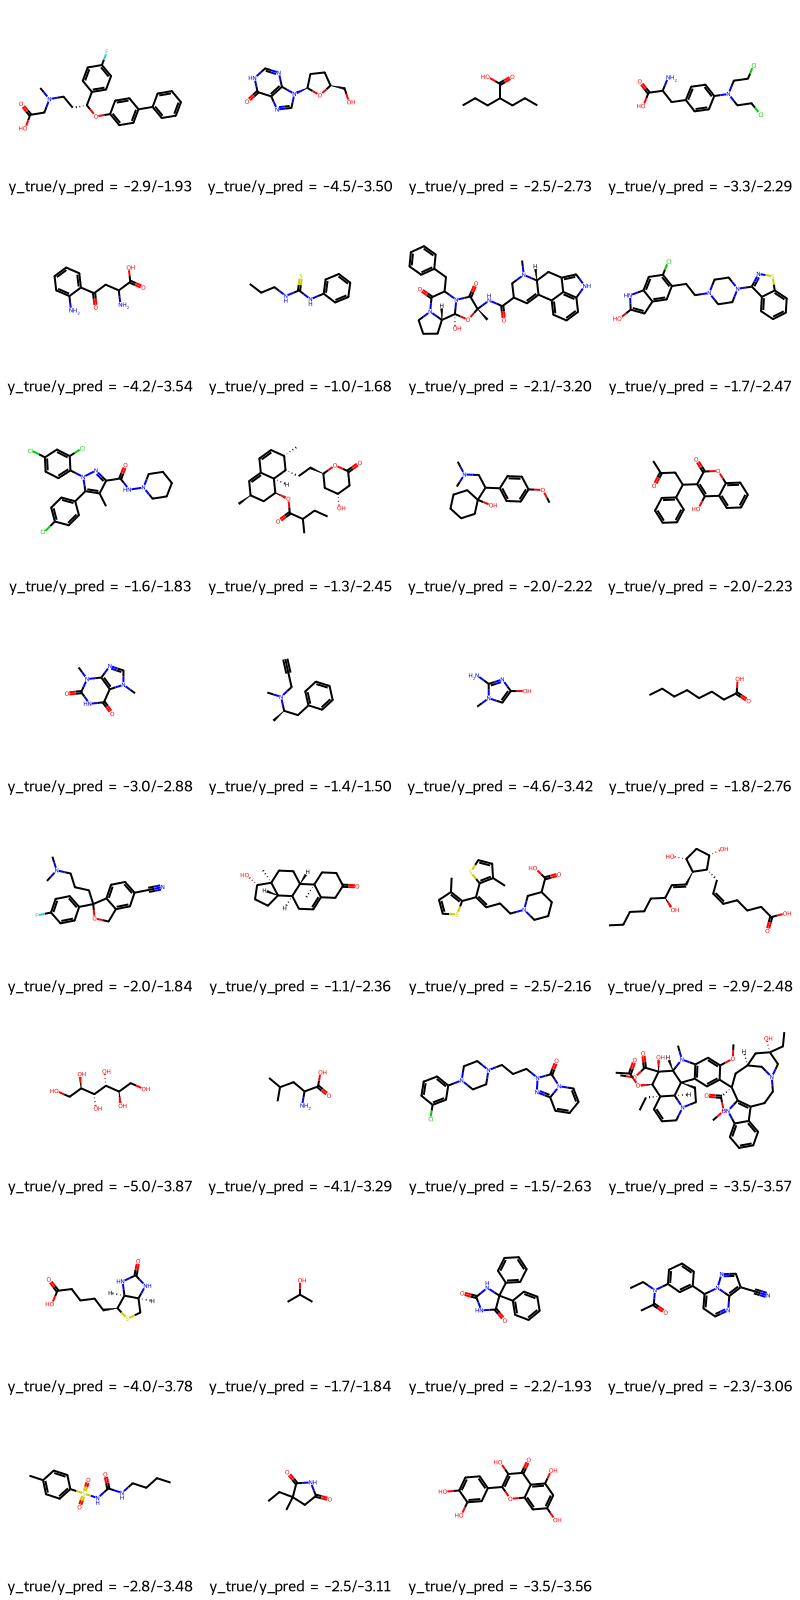

In [ ]:
molecules = [molecule_from_smiles(total.smiles_standarized.values[index]) for index in valid_index]
y_true = [total.label.values[index] for index in valid_index]
y_pred = tf.squeeze(mpnn.predict(valid_dataset), axis=1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)

In [ ]:
valid_dataset = MPNNDataset(x_valid, y_valid)
test_loss, test_mae = mpnn.evaluate(valid_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

predictions = mpnn.predict(valid_dataset)
r2 = r2_score(y_valid, predictions)
print(f"R^2 Score: {r2}")

1/1 [==============================] - 0s 247ms/step - loss: 0.5240 - MAE: 0.6036
Test Loss: 0.5239754915237427
Test MAE: 0.6035997867584229
1/1 [==============================] - 0s 219ms/step
R^2 Score: 0.556484974889141


1/1 [==============================] - 0s 239ms/step
Shape of y_test: (31,)
Shape of y_pred: (31,)
Mean Absolute Error (MAE): 0.6035996798546083
Mean Squared Error (MSE): 0.5239753887714492


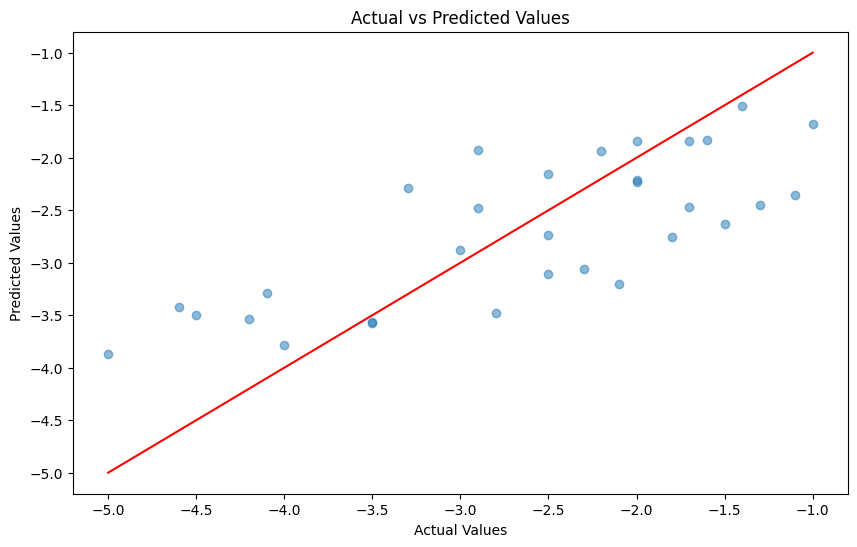

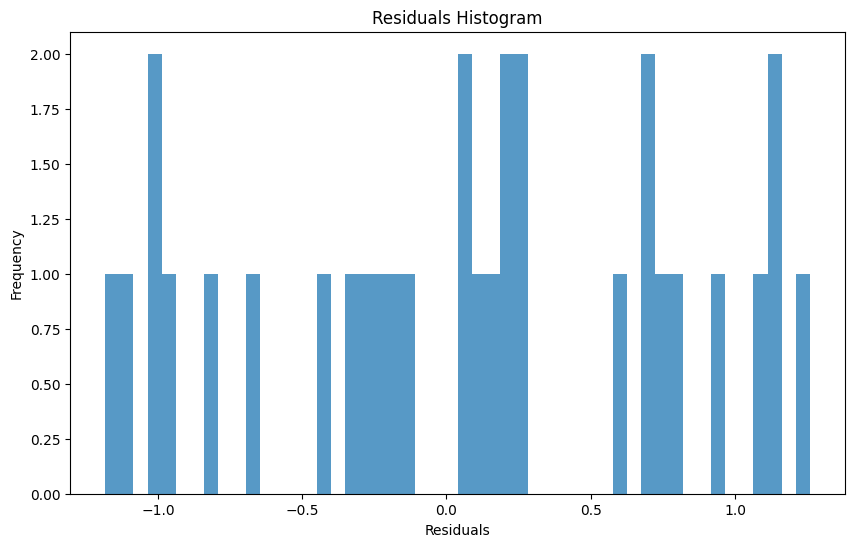

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Load the test dataset and make predictions
test_dataset = MPNNDataset(x_valid, y_valid)
y_pred = mpnn.predict(valid_dataset)

# Ensure y_test and y_pred are numpy arrays
y_test = np.array(y_valid)
y_pred = np.array(y_pred).squeeze()  # Remove the extra dimension if it exists

# Check the shape of y_test and y_pred
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line of perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

# Plot residuals (errors)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.75)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()


In [ ]:
import numpy as np
import scipy.stats as stats

mae_values = np.array([0.5992833971977234,0.6275594234466553,0.7083663940429688,0.46053415536880493,0.6035997867584229])
r2_values = np.array([0.39973028704701086, 0.45074850406599065, 0.5955871935515469, 0.693195470433716, 0.556484974889141])

def calculate_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(n)
    t_score = stats.t.ppf((1 + confidence) / 2.0, n - 1)
    margin_of_error = t_score * std_err
    return mean - margin_of_error, mean + margin_of_error


mae_conf_interval = calculate_confidence_interval(mae_values)
print(f"95% Confidence Interval for MAE: {mae_conf_interval}")


r2_conf_interval = calculate_confidence_interval(r2_values)
print(f"95% Confidence Interval for R-squared: {r2_conf_interval}")


95% Confidence Interval for MAE: (0.48886827157601453, 0.7108689911498155)
95% Confidence Interval for R-squared: (0.3942566921962173, 0.684041879798745)


In [ ]:
l=[0.39973028704701086, 0.45074850406599065, 0.5955871935515469, 0.693195470433716,0.556484974889141]
sum=0
for i in l:
  sum+=i
print(sum/5)

0.5391492859974811
